<div style="color:#8b1538; font-size:32px;">Graphic representation using matplotlib and seaborn</div>

In [1]:
import ast
import json
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sei.files.files as f
import sei.simulation.msprime as ms

<br>

# Common method

> Heatmap personnalization - xaxis and yaxis

In [54]:
def heatmap_axis(ax, xaxis, yaxis, cbar):
    """
    ax: matplotlib.axes.Axes
        ax to modify
    xaxis: str
        x-axis label
    yaxis: str
        y-axis label
    cbar: str
        colormap label
    """
    # Name
    names = ["Log10({})".format(xaxis), "Log10({})".format(yaxis)]  # (xaxis, yaxis)
    
    # x-axis
    plt.xticks(np.arange(64, step=7) + 0.5, labels=[round(ele, 2) for ele in np.arange(-4, 2.5, 0.7)], rotation='horizontal')
    plt.xlabel(names[0], fontsize="large")
    
    # y-axis
    ax.set_ylim(ax.get_ylim()[::-1])  # reverse y-axis
    plt.yticks(np.arange(64, step=7) + 0.5, labels=[round(ele, 2) for ele in np.arange(-3.5, 3, 0.7)])
    plt.ylabel(names[1], fontsize="large")
    
    # Set colorbar label & font size
    ax.figure.axes[-1].set_ylabel(cbar, fontsize="large")

<br>

# SFS shape verification

> Generate data

In [3]:
def simulation_parameters(sample, ne, rcb_rate, mu, length):
    """
    Set up the parametres for the simulation with msprime.
    """
    parameters = {
        "sample_size": sample, "size_population": ne, "rcb_rate": rcb_rate, "mu": mu,
        "length": length
    }
    return parameters


def generate_sfs():
    """
    Return
    ------
    sfs: dictionary
        sfs for various scenario - constant population, theorical sfs for any constant population, decline model,
        growth model and migration model (with no migration finto 2 from 1)
    parameters: dictionary
        specific value of tau & kappa for the growth and decline model
        specifiv value of m12, m21 & kappa for the migration model
    """
    # Dictionary
    sfs, parameters = {}, {}
    
    # Parameters for the simulation
    params_simulation = simulation_parameters(sample=10, ne=1, rcb_rate=2e-2, mu=2e-2, length=1e5)

    # Constant scenario
    sfs_cst = ms.msprime_simulation(model=ms.constant_model, params=params_simulation, debug=True)
    sfs['Constant model'] = sfs_cst
    
    # Theoretical SFS for any constant population
    sfs_theorique = [0] * (params_simulation["sample_size"] - 1)
    for i in range(len(sfs_theorique)):
        sfs_theorique[i] = 1 / (i+1)
    sfs['Theoretical model'] = sfs_theorique

    # Define tau & kappa for decline/growth scenario
    params_simulation.update({"Tau": 1.0, "Kappa": 10.0})

    sfs['Decline model'] = ms.msprime_simulation(model=ms.sudden_decline_model, params=params_simulation, debug=True)
    parameters['Decline model'] = {k: v for k, v in params_simulation.items() if k in ['Tau', 'Kappa']}

    sfs['Growth model'] = ms.msprime_simulation(model=ms.sudden_growth_model, params=params_simulation, debug=True)
    parameters['Growth model'] = {k: v for k, v in params_simulation.items() if k in ['Tau', 'Kappa']}

    # Migration scenario
    params_simulation.update({"Kappa": 10.0, "m12": 1.0, "m21": 0})
    
    sfs['Migration model'] = ms.msprime_simulation(model=ms.two_pops_migration_model, params=params_simulation, debug=True)
    parameters['Migration model'] = {k: v for k, v in params_simulation.items() if k in ['m12', 'm21', 'Kappa']}

    return sfs, parameters, {k: v for k, v in params_simulation.items() if k not in ['m12', 'm21', 'Kappa', 'Tau']}


def load_sfs(generate=False):
    if generate:
        all_sfs, params, params_simulation = generate_sfs()
        with open("./Data/Msprime/sfs_shape_verification", 'w') as filout:
            filout.write("SFS shape verification and simulations parameters - {}\n".format(params_simulation))
           
            for model, sfs in all_sfs.items():
                if model in params.keys():
                    filout.write("{} - {} - {}\n".format(model, sfs, params[model]))
                else:
                    filout.write("{} - {}\n".format(model, sfs))
    
    else:
        all_sfs, params = {}, {}
        with open("./Data/Msprime/sfs_shape_verification", 'r') as filin:
            lines = filin.readlines()
            params_simulation = ast.literal_eval(lines[0].strip().split(' - ')[1])
            
            for line in lines[1:]:
                tmp = line.strip().split(' - ')
                if tmp[0] not in ['Constant model', 'Theoretical model']:
                    params[tmp[0]] = ast.literal_eval(tmp[2])
                all_sfs[tmp[0]] = json.loads(tmp[1])
        
    return all_sfs, params, params_simulation

<br>

> Plot data

In [4]:
def plot_sfs(data):
    """
    Graphic representation of Site Frequency Spectrum (SFS), save to the folder ./Figures.

    Parameter
    ---------
    sfs: list
        list of sfs to plot
    label: list
        the label of each sfs
    color: list
        the color of each curve
    style: list
        the linestyle
    title: string
        title of the plot
    """
    color = ["tab:blue", "tab:orange", "tab:red", "tab:green", "tab:gray"]
    
    # Set up plot
    plt.figure(figsize=(12,9), constrained_layout=True)
    
    cpt = 0
    for key, sfs in data[0].items():
        # Normalization of SFS - sum to 1
        normalized_sfs = [ele / sum(sfs) for ele in sfs]
        
        # Label
        if key in ['Constant model', 'Theoretical model']:
            label = key
        else:
            label = "{} - {}".format(key, data[1][key])
    
        # Plot
        plt.plot(normalized_sfs, color=color[cpt], label=label)
        
        cpt += 1
        
    # Caption
    plt.legend(loc="upper right", fontsize="x-large")

    # Label axis
    plt.xlabel("Allele frequency", fontsize="x-large")
    plt.ylabel("Percent of SNPs", fontsize="x-large")

    # X axis values
    x_ax, x_values = [], []
    for i in range(len(sfs)):
        x_ax.append(i)
        x_values.append("{}/{}".format(i+1, len(sfs)+1))
    plt.xticks(x_ax, x_values)

    # Title + show
    title = "Unfold SFS for various scenario with Ne={}, mu={}, rcb={}, L={:.1E}" \
        .format(data[2]['size_population'], data[2]['mu'], data[2]['rcb_rate'], round(data[2]['length']))
    plt.title(title, fontsize="xx-large")
    plt.show()

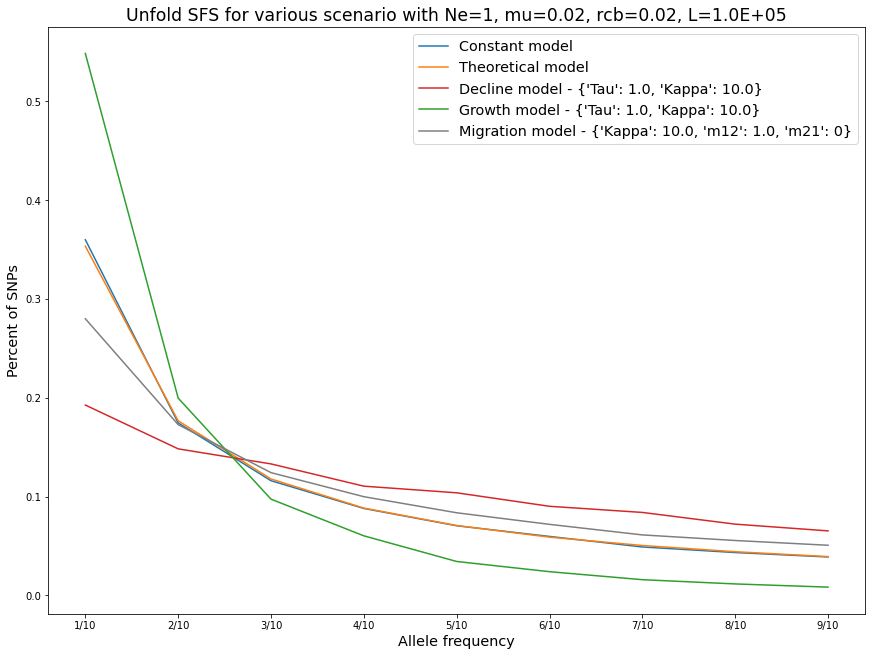

In [5]:
plot_sfs(load_sfs())

**Constant model**. Constant size population model. **Theoritical model**. Theoritical SFS for any constant population. **Decline model**. sudden decline of an ancestral population of size Ne\*kappa to size Ne at a time tau in the past. **Growth model**. sudden growth of an ancestral population of size Ne to size Ne\*kappa at a time tau in the past. **Migration model**. migration model of two populations pop1 and pop2 of size Ne and Ne\*kappa respectively. m12 is the migration rate into 1 from 2 and m21 is the migration rate into 2 from 1 (by default m21 s 0)

<br>

# SNPs distribution

> Load data

In [3]:
def load_data(model, path_data):
    data = pd.read_json(path_or_buf="{}SFS_{}-all.json".format(path_data, model), typ='frame')
    
    return data

<br>

> Data pre-processing

In [7]:
def data_preprocessing(sfs):
    """
    Pre processing for the plot.
    """
    # New pandas DataFrame
    data = pd.DataFrame()
    
    # Compute log10 of parameters - either (tau, kappa) or (m12, kappa)
    keys = sfs['Parameters'][0].keys()
    names = []
    for key in keys:
        if key in ['Tau', 'Kappa', 'm12']:
            names.append(key)
            data[key] = sfs['Parameters'].apply(lambda param: param[key])
    
    # Compute mean(SNPs)
    data['SNPs'] = sfs['SNPs'].apply(lambda snp: np.log10(np.mean(snp)))

    return data.pivot(names[1], names[0], 'SNPs')

<br>

> Plot data

In [8]:
def plot_snp_distribution(data, model):
    # Set-up plot
    plt.figure(figsize=(12,9), constrained_layout=True)
    sns.set_theme(style='whitegrid')

    # Plot
    ax = sns.heatmap(data, cmap="coolwarm")
    
    # Heatmap x and y-axis personnalization
    heatmap_axis(ax=ax, xaxis=data.columns.name, yaxis=data.index.name)
    
    # Title
    title = "SNPs distribution in terms of {} & {} - {} model".format(data.columns.name, data.index.name, model)
    plt.title(title, fontsize="x-large", color="#8b1538")
    
    plt.show()

<br>

### SNPs distribution - decline model

> By default

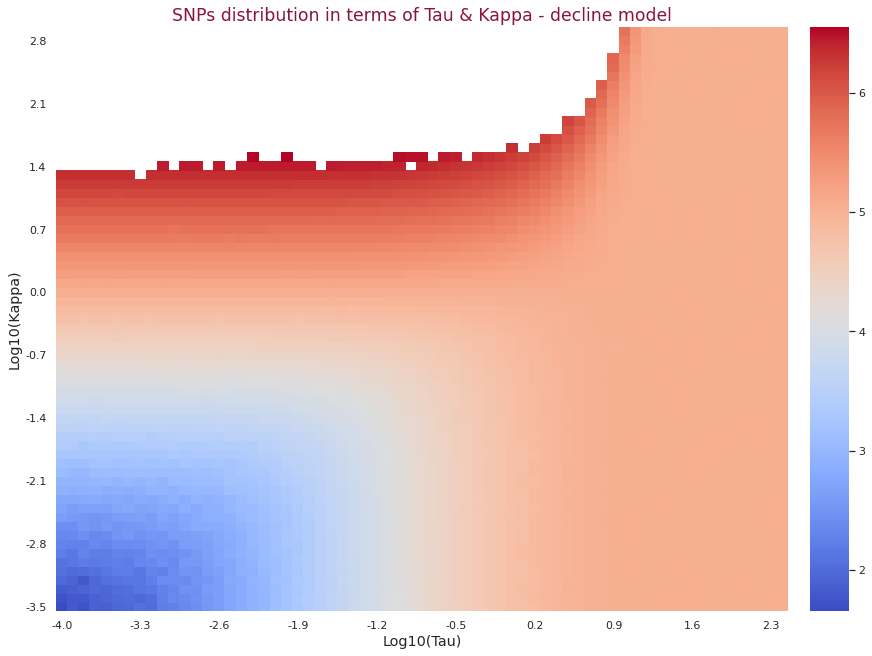

In [9]:
model, path_data = "decline", "./Data/Msprime/snp_distribution/sfs_decline-default/"
data = data_preprocessing(load_data(model, path_data))
plot_snp_distribution(data, model)

Il y a une grande disparité dans le nombre de SNPs en fonction de tau & kappa.

<br>

> About 100 000 SNPs for each observed SFS

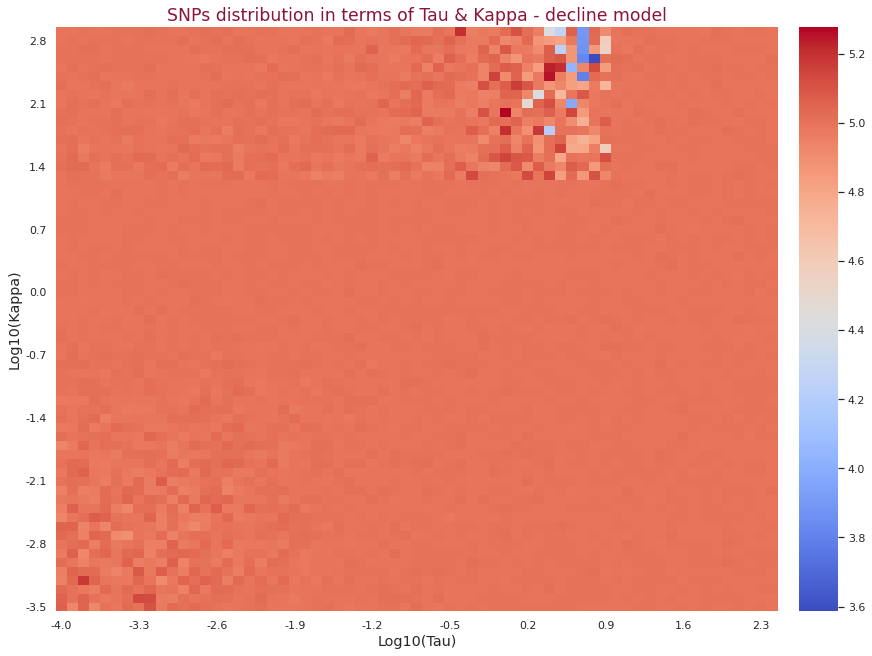

In [10]:
model, path_data = "decline", "./Data/Msprime/snp_distribution/sfs_decline/"
data = data_preprocessing(load_data(model, path_data))
plot_snp_distribution(data, model)

<br>

# Dadi inference

## Weighted square distance

The weighted square distance $\large{d^2}$ is:

1. Between the observed SFS $\large{\eta^{obs}}$ and the predicted SFS by model M1 $\large{\eta^{model}}$

\begin{equation}
\Large{ d^2(\eta^{model}, \eta^{obs}) = \sum_{i=1}^{n}{\frac{(\eta^{model}_i - \eta^{obs}_i)^2}{\eta^{model}_i }} }
\end{equation}

2. Between the inferred SFS of two models ($\large{\eta^{m2}}$ & $\large{\eta^{m1}}$)

\begin{equation}
\Large{ d^2(\eta^{m0}, \eta^{m1}) = \sum_{i=1}^{n}{\frac{(\eta^{m0}_i - \eta^{m1}_i)^2}{ (\eta^{m0}_i + \eta^{m1}_i) / 2 }} }
\end{equation}

Start the sum from 2 to ignore singletion (i=2).

<div class="alert alert-warning">Each SFS must be normalized for comparison</div>

<br>

### Pre-processing data (SFS normalization) and compute the weighted square distance

In [31]:
def normalization(sfs):
    """
    Return a normalized sfs
    """
    return [ele / sum(sfs) for ele in sfs]


def compute_weighted_square_distance(sfs):
    if "Observed" in sfs.keys():
        d2 = [
            np.power(eta_model - eta_obs, 2) / eta_model for eta_obs, eta_model in zip(sfs['Observed'], sfs['Model'])
        ]
    else:
        d2 = [
            np.power(eta_m0 - eta_m1, 2) / (np.mean([eta_m0, eta_m1])) for eta_m0, eta_m1 in zip(sfs['M0'], sfs['M1'])
        ]
    return sum(d2)


def data_weighted_square_distance(data):
    df = pd.DataFrame()
    
    # 1. Compute log 10 of tau & kappa
    for key in data['Parameters'][0].keys():
        if key in ['Tau', 'm12', 'Kappa']:
            df[key] = data['Parameters'].apply(lambda ele: np.log10(ele[key]))

    # 2. Normalization
    data['SFS observed'] = data['SFS observed'].apply(lambda x: [normalization(ele) for ele in x])
    data['M0'] = data['M0'].apply(
        lambda x: {k: ([normalization(ele) for ele in v] if k == 'SFS' else v) for k, v in x.items()}
    )
    data['M1'] = data['M1'].apply(
        lambda x: {k: ([normalization(ele) for ele in v] if k == 'SFS' else v) for k, v in x.items()}
    )
    
    # 2. Compute weighted square distance
    d2_observed_inferred = {}  # d2 between the observed SFS and inferred one with M1
    d2_models = {}  # d2 between the inferred SFS of two models (M0 & M1)
    
    for i, row in data.iterrows():
        
        # Iterate over all the normalized observed SFS & normalized inferred SFS with M1
        tmp = []
        for sfs_observed, sfs_inferred in zip(row['SFS observed'], row['M1']['SFS']):
            tmp.append(compute_weighted_square_distance({'Observed': sfs_observed, 'Model': sfs_inferred}))
        d2_observed_inferred[i] = np.log10(np.mean(tmp))
            
        # Iterate over all the normalized inferred SFS with M0 & M1
        tmp = []
        for sfs_m0, sfs_m1 in zip(row['M0']['SFS'], row['M1']['SFS']):
            tmp.append(compute_weighted_square_distance({'M0': sfs_m0, 'M1': sfs_m1}))
        d2_models[i] = np.log10(np.mean(tmp))
        
    # Add new columns to DataFrame data from dictionary
    df['d2 observed inferred'] = pd.Series(d2_observed_inferred)
    df['d2 models'] = pd.Series(d2_models)
            
    return df

<br>

### Plot the weighted square distance

> Heatmap

In [58]:
def plot_weighted_square_distance_heatmap(data, d2, models):
    # Set-up plot
    plt.figure(figsize=(12,9), constrained_layout=True)
    sns.set_theme(style='whitegrid')
    
    # Data
    df = data.pivot(index=data_all.columns[1], columns=data_all.columns[0], values=d2)
    
    # Plot
    ax = sns.heatmap(df, cmap="coolwarm")
    
    # Heatmap x and y-axis personnalization
    heatmap_axis(ax=ax, xaxis=df.columns.name, yaxis=df.index.name, cbar='Weighted square distance - log scale')
    
    # Title
    title = "Weighted square d2 of {} & {} models".format(models[0], models[1])
    plt.title(title, fontsize="x-large", color="#8b1538")
    
    plt.plot()

<br>

In [33]:
data_all = data_weighted_square_distance(f.export_inference_files('decline', 'all'))

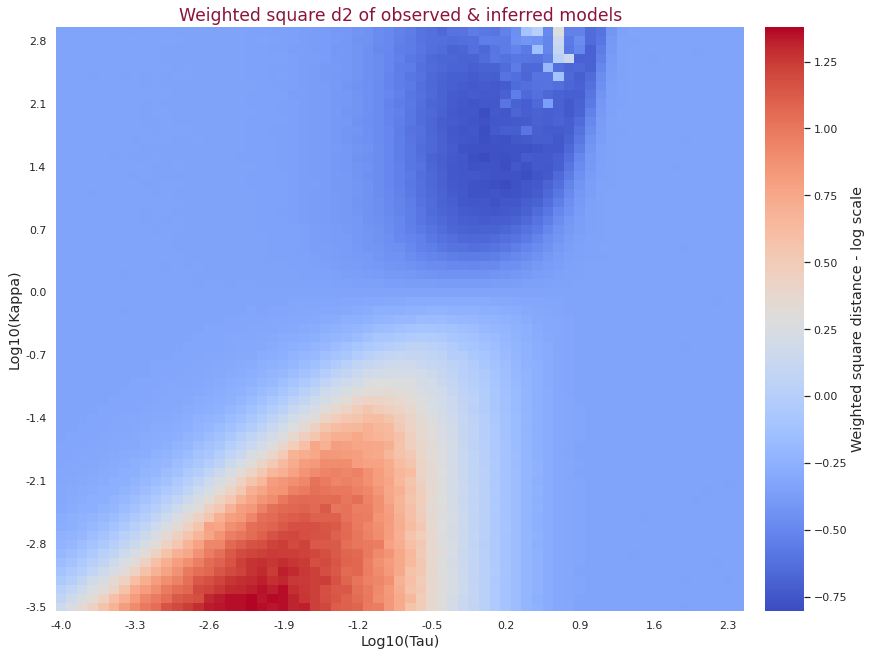

In [59]:
plot_weighted_square_distance_heatmap(data_all, 'd2 observed inferred', ['observed', 'inferred'])

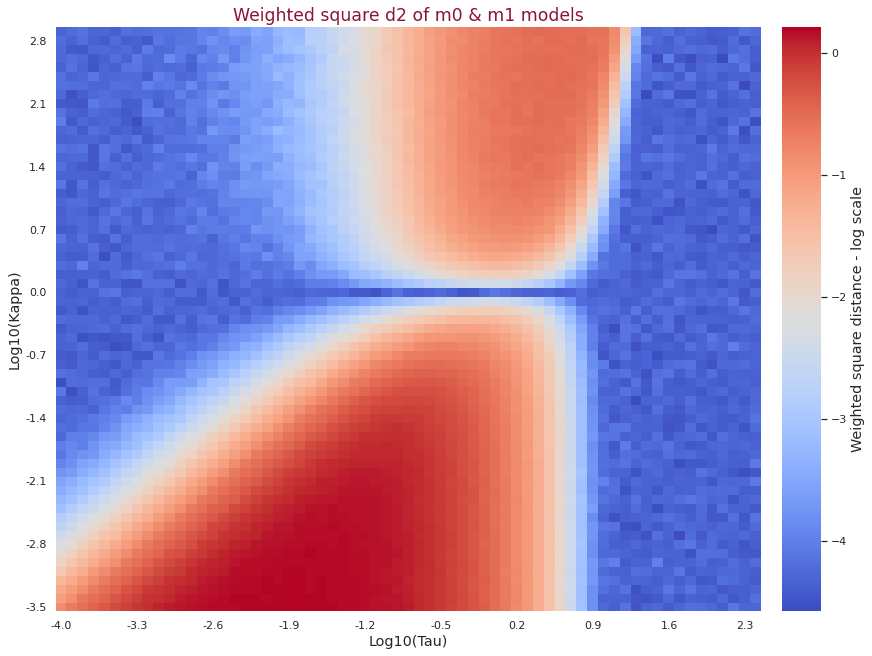

In [60]:
plot_weighted_square_distance_heatmap(data_all, 'd2 models', ['m0', 'm1'])

<br>

> For a fixed kappa or tau

In [36]:
def plot_weighted_square_distance(data, key, labels, suptitle):
    d2 = ['d2 observed inferred', 'd2 models']
    title = [
        'd2 between the observed SFS and inferred one with M1', 
        'd2 between the inferred SFS of two models (M0 & M1)'
    ]
    
    # Set-up plot
    sns.set_theme(style='whitegrid')
    
    # Sub-plots
    fig, axs = plt.subplots(1, 2, figsize=(20, 8))  # Figsize: (width, height)
    
    # Plot
    for i, ax in enumerate(axs):  # Iterate through subplot
        
        for j, df in enumerate(data):  # Iterate through DataFrame in data
            _ = sns.lineplot(x=key, y=d2[i], data=df, label=labels[j], ax=ax)
        
        ax.legend(fontsize="large")
        ax.set_title(title[i], fontsize="large")
        
    plt.suptitle(suptitle, fontsize="x-large")
    
    plt.plot()

<br>

In [37]:
data_2 = data_weighted_square_distance(f.export_inference_files('decline', 'kappa', 2))
data_10 = data_weighted_square_distance(f.export_inference_files('decline', 'kappa', 10))

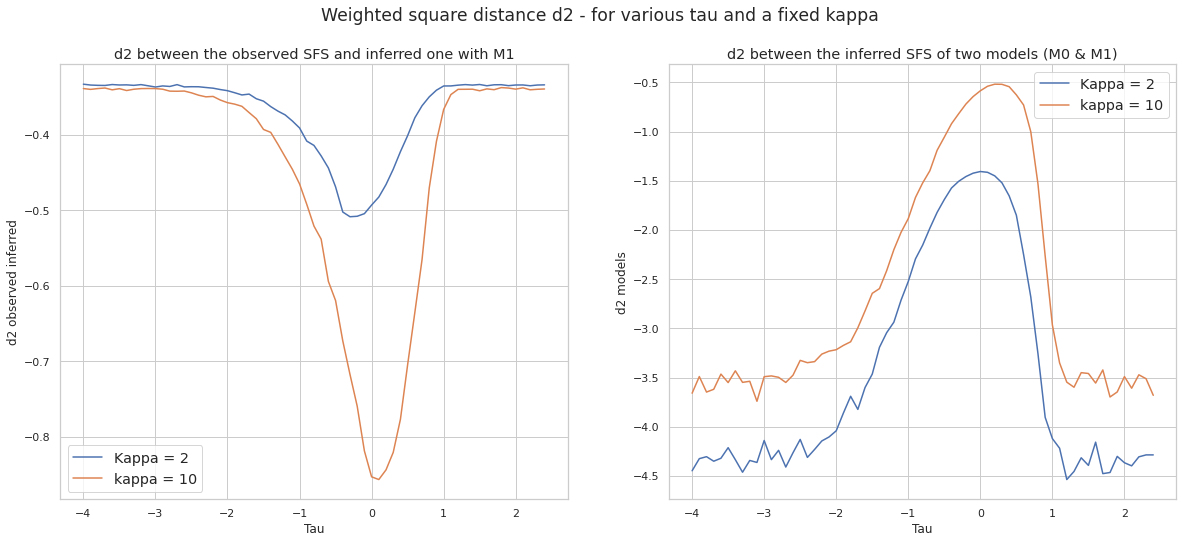

In [38]:
plot_weighted_square_distance(
    data=[data_2, data_10], key="Tau", 
    labels=['Kappa = 2', 'kappa = 10'],
    suptitle="Weighted square distance d2 - for various tau and a fixed kappa")

<br>

In [19]:
data = data_weighted_square_distance(f.export_inference_files('decline', 'tau', 1))

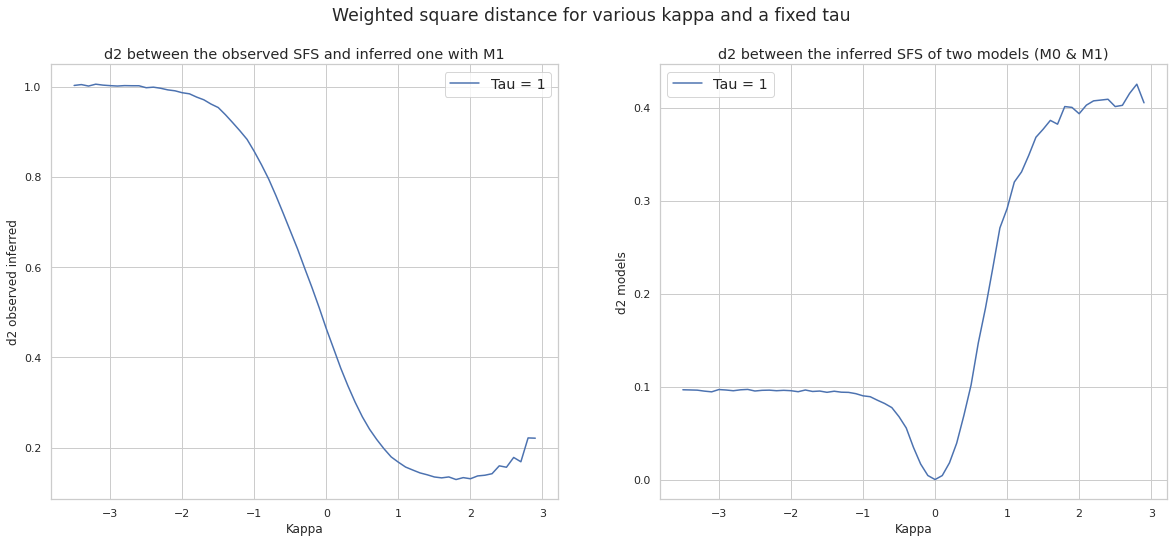

In [20]:
plot_weighted_square_distance(
    data=[data], key="Kappa", 
    labels=['Tau = 1'],
    suptitle="Weighted square distance for various kappa and a fixed tau")

<br>

## Plot 

> Data pre-processing

In [63]:
def data_preprocessing_heatmap(data):
    keys = data['Parameters'][0].keys()
    
    # Compute log10
    name = []
    for key in keys:
        if key in ['Tau', 'Kappa', 'm12']:
            name.append(key)
            data[key] = data['Parameters'].apply(lambda ele: np.log10(ele[key]))
    
    return data.pivot(name[0], name[1], 'Positive hit')

<br>

> Plot

In [67]:
def plot_inference_dadi_heatmap(data):
    # Set-up plot
    plt.figure(figsize=(12,9), constrained_layout=True)
    sns.set_theme(style='whitegrid')
    
    # Pre-processing data
    df = pd.DataFrame()

    for key in data['Parameters'][0].keys():
        df[key] = data['Parameters'].apply(lambda param: np.log10(param[key]))  # Log10 of parameters (tau, kappa) or (m12, kappa)

    df['Positive hit'] = data['Positive hit']  # Add positive hit columns to df
    
    df = df.pivot(df.columns[1], df.columns[0], 'Positive hit')  # Pivot
    
    # Plot
    ax = sns.heatmap(df, cmap="coolwarm")
    
    # Heatmap x and y-axis personnalization
    heatmap_axis(ax=ax, xaxis=df.columns.name, yaxis=df.index.name, cbar='Significant log-likelihood ratio test out of 100 tests')
    
    # Title
    title = "Log likelihood ratio test for various tau & kappa with p.value = 0.05"
    plt.title(title, fontsize="x-large", color="#8b1538")
    
    plt.plot()

<br>

In [65]:
data = f.export_inference_files('decline', 'all')

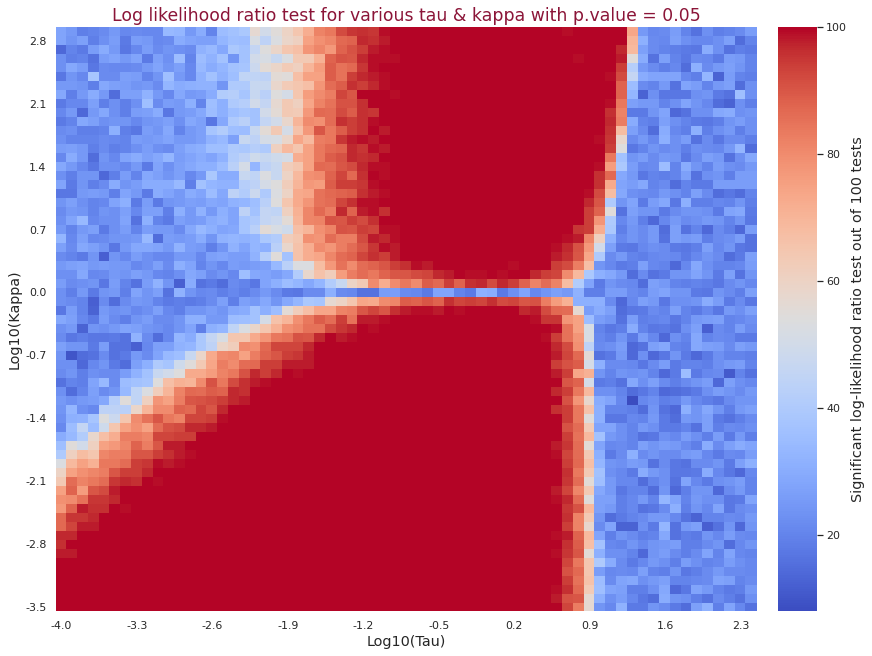

In [68]:
plot_inference_dadi_heatmap(data)

<br>

In [9]:
def plot_inference_dadi(data, key, labels, suptitle):
    # Set-up plot
    plt.figure(figsize=(10,8), constrained_layout=True)
    sns.set_theme(style='whitegrid')
    
    # Plot
    for i, df in enumerate(data):
        df[key] = df['Parameters'].apply(lambda param: np.log10(param[key]))
        ax = sns.lineplot(x=key, y='Positive hit', data=df, label=labels[i])
    ax.legend(fontsize="large")
    
    plt.suptitle(suptitle, fontsize="x-large")
    
    plt.plot()

<br>

In [37]:
data_2 = f.export_inference_files('decline', 'kappa', 2)
data_10 = f.export_inference_files('decline', 'kappa', 10)

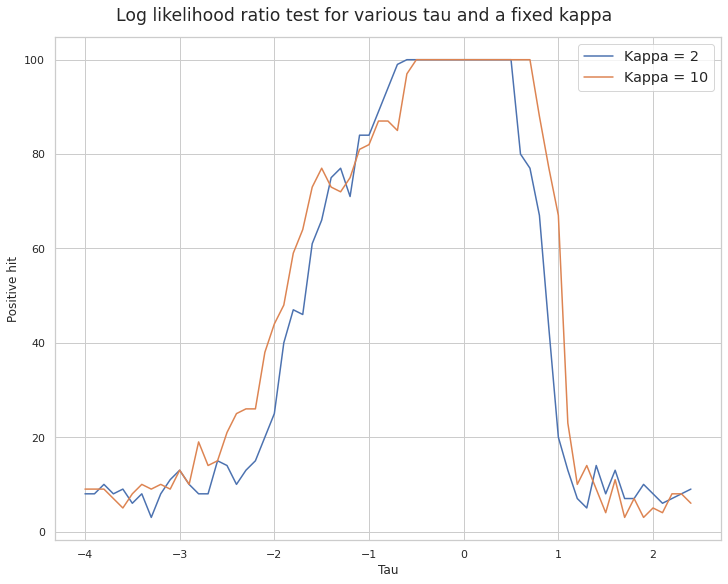

In [46]:
plot_inference_dadi(
    data=[data_2, data_10], key="Tau",
    labels=['Kappa = 2', 'Kappa = 10'],
    suptitle="Log likelihood ratio test for various tau and a fixed kappa")

<br>

In [75]:
data = f.export_inference_files('decline', 'tau', 1)

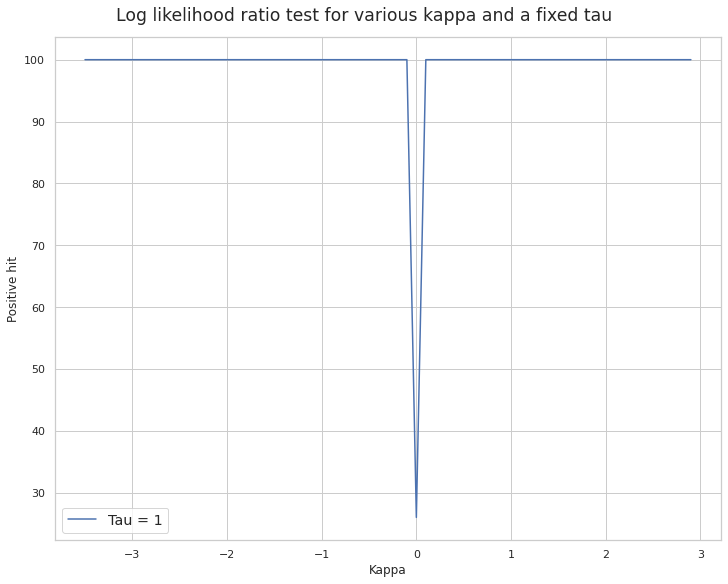

In [76]:
plot_inference_dadi(
    data=[data], key="Kappa",
    labels=['Tau = 1'],
    suptitle="Log likelihood ratio test for various kappa and a fixed tau")

<br>

In [91]:
float("dadi-decline-tau=0.0001-1".split("=")[1].split('-')[0]) == 0.0001

True

In [92]:
f.export_inference_files('decline', 'tau', 0.0001)

,Parameters,Positive hit,SNPs,SFS observed,M0,M1,Time


In [71]:
data = []
for value in np.arange(-4, -2.4, 0.1):
    data.append(f.export_inference_files('decline', 'tau', np.power(10, np.power(10, value))))

In [95]:
fichiers = os.listdir("./Data/Dadi/decline/tau/")
fichiers = [ele for ele in fichiers if float(ele.split('=')[1].split('-')[0]) == 0.0001]
for fichier in fichiers:
    res = pd.read_json("../D")

['dadi-decline-tau=0.0001-3',
 'dadi-decline-tau=0.0001-22',
 'dadi-decline-tau=0.0001-62',
 'dadi-decline-tau=0.0001-42',
 'dadi-decline-tau=0.0001-8',
 'dadi-decline-tau=0.0001-39',
 'dadi-decline-tau=0.0001-26',
 'dadi-decline-tau=0.0001-55',
 'dadi-decline-tau=0.0001-14',
 'dadi-decline-tau=0.0001-5',
 'dadi-decline-tau=0.0001-63',
 'dadi-decline-tau=0.0001-44',
 'dadi-decline-tau=0.0001-45',
 'dadi-decline-tau=0.0001-52',
 'dadi-decline-tau=0.0001-6',
 'dadi-decline-tau=0.0001-4',
 'dadi-decline-tau=0.0001-18',
 'dadi-decline-tau=0.0001-20',
 'dadi-decline-tau=0.0001-25',
 'dadi-decline-tau=0.0001-48',
 'dadi-decline-tau=0.0001-54',
 'dadi-decline-tau=0.0001-43',
 'dadi-decline-tau=0.0001-36',
 'dadi-decline-tau=0.0001-46',
 'dadi-decline-tau=0.0001-33',
 'dadi_decline_tau=0.0001-1',
 'dadi-decline-tau=0.0001-27',
 'dadi-decline-tau=0.0001-49',
 'dadi-decline-tau=0.0001-51',
 'dadi-decline-tau=0.0001-34',
 'dadi-decline-tau=0.0001-16',
 'dadi-decline-tau=0.0001-53',
 'dadi-decline